In [15]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import lmfit

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# only S21 dBm has factor of 20, otherwise it'd be a factor of 10
# this is because P = V^2/R, so the V^2 gives an extra factor of 2

def s21_dbm_to_lin(dbm_ampl):
    return np.log10(dbm_ampl) * 20  

def s21_lin_to_dbm(lin_ampl):
    return 10**(lin_ampl/20)

def load_csv(path):
    
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(path, header=None)
    freqs = df[0].to_numpy()
    amps_dB = df[1].to_numpy()
    phases_init = df[2].to_numpy()

    max_phase_value = np.max(phases_init)
    min_phase_value = np.min(phases_init)
    if (max_phase_value > 2 * np.pi) or (min_phase_value < -2 * np.pi): #check if phases are in degrees or radians, convert as needed
        #phases are in degrees, we need to convert
        phases_new = np.unwrap(np.deg2rad(phases_init))
    else:
        #phases are in radians, good to go
        phases_new = np.unwrap(phases_init)

    return freqs, amps_dB, phases_new

def load_all_csvs_in_path(path, key='*', idx=None):
    """AI is creating summary for load_all_csvs_in_path

    Args:
        path ([type]): [description]
        key (str, optional): [description]. Defaults to '*'.
        idx ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data_files = glob.glob(path + key)
    
    if idx is not None:  # user wants to load a single file from dir
        idx = 0 if len(data_files) == 1 else idx  # set idx to 0 if there's only one file
        file = data_files[idx]
        df = pd.read_csv(file, sep=",", names=['Frequency','dBm','Phase'])
        freq = np.array(df['Frequency'])
        ampl = s21_lin_to_dbm(df['dBm'])
        phase = np.unwrap(np.deg2rad(df['Phase']))
        cmplx = ampl * np.exp(1j*phase)
        
        return freq, cmplx, df
    
    elif idx is None and len(data_files) != 1:  
        freq_dict, cmplx_dict, df_dict = {}, {}, {}
        for filepath in data_files:
            filename = os.path.basename(filepath)
            df = pd.read_csv(filepath, sep=",", names=['Frequency','dBm','Phase'])
            freq = np.array(df['Frequency'])
            ampl = s21_lin_to_dbm(df['dBm'])
            phase = np.unwrap(np.deg2rad(df['Phase']))
            cmplx = ampl * np.exp(1j*phase)
            
            freq_dict[filename] = freq
            cmplx_dict[filename] = cmplx
            df_dict[filename] = df
            
        return freq_dict, cmplx_dict, df_dict
        
    else:
        # idx is None and len(data_files) == 1
        print(f"idx={idx}, len(data_files)={len(data_files)}\n failed if & elif")
        raise
        
def preprocess_csv(file_path):
    """
    Preprocess a CSV file into a DataFrame. The CSV file is read starting from line 6,
    and the data in the first column is separated into respective columns by spaces.

    Parameters:
    file_path (str): Path to the input CSV file.

    Returns:
    pd.DataFrame: Preprocessed DataFrame with separated columns.
    """
    # Read the CSV file starting from line 6
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the headers (assuming the first row from line 6 contains headers)
    headers = lines[5].strip().split()
    
    # Extract the data starting from line 7
    data = [line.strip().split() for line in lines[6:]]
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=headers)

    df = df.astype(float)

    return df


# load data from sample directory
data_path = 'test_data/Cooldown53/Line3_NWNb2O5_15_01/NWNb2O5_15_01_5p757GHz/NWNb2O5_15_01_5p757GHz_-40dB_11mK_homophasal.csv'

freqs, amps_dB, phases = load_csv(data_path)
# print(df)

# print(freqs)
# print(amps_dB)
# print(phases)
cmplx = amps_dB * np.exp(1j*phases)
# print(cmplx)

## Testing scresonators

In [17]:
cur_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(cur_dir))

#For Zach
# this notebook is located in C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9/scresonators/test
# so the parent's parent directory is C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9
# and by adding that to our path, we can import C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9

#For Jorge
# this notebook is located in E:/GitHub/scresonators/test_ontebooks
# so the parent's parent directory is just E:/GitHub
# and by adding that to our path, we can import E:/GitHub/scresonators
sys.path.append(parent_parent_dir)
print(os.getcwd())

import scresonators.src as scres
print("\nimported scresonators!\n")


def print_dir(module, filter_underscore=True, text=""):
    if filter_underscore == True:
        print("showing dir({})".format(text))
        display( [i for i in dir(module) if '__' not in i] )
    else:
        print("showing dir({})".format(text))
        display( dir(module) )


print_dir(scres.fit_methods.dcm, True, "src.fit_methods.dcm")
print_dir(scres.fit_methods.dcm.DCM, True, "src.fit_methods.dcm.DCM")

dcm_method = scres.fit_methods.dcm.DCM()
FitRes = scres.Fitter(dcm_method)

w1 = freqs[np.abs(cmplx).argmin()]
init_guess = {
    'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
    'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_params = lmfit.create_params(**init_guess)
init_params.pretty_print()
print()

amps = np.abs(cmplx)
db_amps = np.log10(amps) * 20

phases = np.angle(cmplx)
result, conf_intervals = FitRes.fit(freqs, db_amps, phases, manual_init=init_params, verbose=True)

fit_result_params = result.params


c:\Users\zachm\OneDrive\Documents\GitHub\zachmiles9\scresonators\test

imported scresonators!

showing dir(src.fit_methods.dcm)


['DCM', 'FitMethod', 'find_circle', 'lmfit', 'np']

showing dir(src.fit_methods.dcm.DCM)


['_abc_impl', 'create_model', 'find_initial_guess', 'func']

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+06     1000    1e+09     None     True     None     None
Qc      1e+05     1000    1e+09     None     True     None     None
phi      0.08   -1.571    1.571     None     True     None     None
w1   5.765e+09 5.765e+09 5.765e+09     None     True     None     None



c:\Users\zachm\OneDrive\Documents\GitHub\zachmiles9\scresonators\src\fitter.py:323: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  fr_guess, theta_guess = spopt.leastsq(residuals_fr_theta, [fr_guess, theta_guess])[0]


[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 204
    # variables        = 4
    chi-square         = 5.96775480
    reduced chi-square = 0.02983877
    Akaike info crit   = -712.476841
    Bayesian info crit = -699.204361
    R-squared          = -5.9678e+15
[[Variables]]
    Q:    1.7472e+08 +/- 1.0501e+14 (60099791.90%) (init = 1000000)
    Qc:   76099984.4 +/- 2.5151e+11 (330496.10%) (init = 100000)
    w1:   5.7648e+09 +/- 9920244.45 (0.17%) (init = 5.764833e+09)
    phi:  1.57079632 +/- 71.0833293 (4525.31%) (init = 0.08)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, phi) = -1.0000
    C(Qc, w1) = +1.0000
        99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Q  :      -inf      -inf      -inf174717760.15622      +inf      +inf      +inf
 Qc :      -inf      -inf      -inf76099984.35806      +inf      +inf      +inf
 w1 :      -inf      -inf      -inf5764830

c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(Q=139774208.1249779) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(Q=209661312.1874668) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(Qc=45659990.6148344) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(Qc=91319981.22966878) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(w1=5764830300.359369) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scre

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q    1.747e+08     1000    1e+09 1.05e+14     True     None     None
Qc   7.61e+07     1000    1e+09 2.515e+11     True     None     None
phi     1.571   -1.571    1.571    71.08     True     None     None
w1   5.765e+09 5.765e+09 5.765e+09 9.92e+06     True     None     None
60099791.901301526 174717760.15622234 105005010268504.73

abs(data):  [21.28894997 21.48147011 21.55306625 21.58867073 21.61206055 21.62625122
 21.63739967 21.64526939 21.65090179 21.65665436 21.65982819 21.66171646
 21.6653862  21.66879463 21.67144585 21.67270088 21.67487526 21.67658043
 21.67885208 21.67968559 21.68115234 21.68286896 21.68420601 21.68555641
 21.6878624  21.68940163 21.69015884 21.69280052 21.69492531 21.69717026
 21.70098877 21.70250893 21.70545578 21.70961189 21.71457481 21.72010803
 21.7263031  21.73455048 21.74373627 21.75569916 21.77099228 21.79332542
 21.82065582 21.86090851 21.91892815 22.00881958 22.16306305 22.4497242

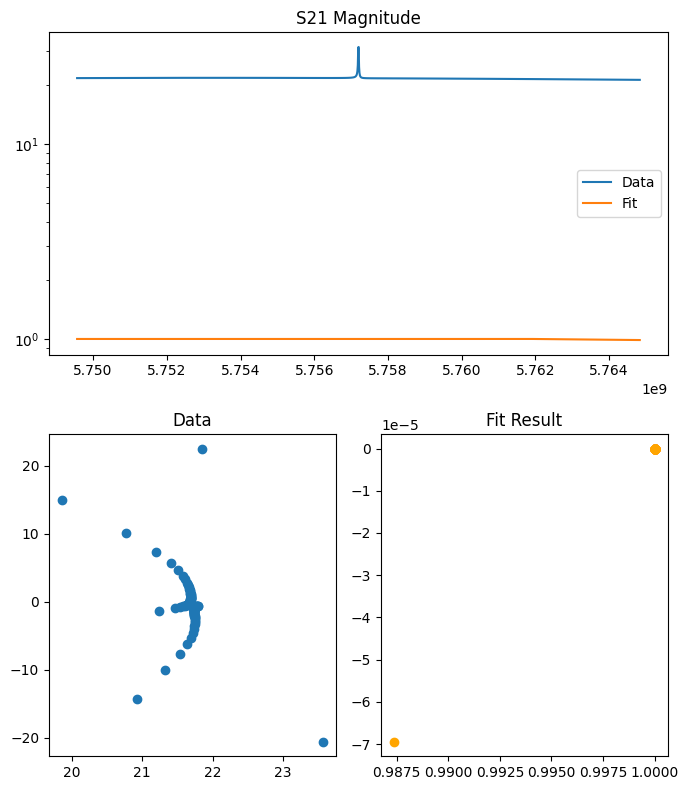

In [18]:
fit_result_params.pretty_print()

y_fit = result.eval(params=fit_result_params, x=freqs)
# y_fit_err = result.eval_uncertainty()
Q_val = fit_result_params["Q"].value
Q_err = fit_result_params["Q"].stderr
dQ = 100 * Q_err/Q_val
print(dQ, Q_val, Q_err)

print("\nabs(data): ", np.abs(cmplx))
print("abs(result): ", np.abs(y_fit))

##########################################
#############    plotting   ##############
##########################################

mosaic = "AAAA\n BBCC"
fig, axes = plt.subplot_mosaic(mosaic, figsize=(7,8))
ax1, ax2, ax3 = axes["A"], axes["B"], axes["C"]

ax1.plot(freqs, np.abs(cmplx), label="Data")
ax1.plot(freqs, np.abs(y_fit), label="Fit")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("S21 Magnitude")

ax2.plot(np.real(cmplx), np.imag(cmplx), label="Data", linestyle='', marker='o')
ax2.set_title("Data")

ax3.plot(np.real(y_fit), np.imag(y_fit), label="Fit", linestyle='', marker='o', color='orange')
ax3.set_title("Fit Result")


fig.tight_layout()

## Multiple Resonators

to be implemented

In [19]:
# # load data from Andre
# data_dir = './samples/R0_Jorge/'
# chosen_files = '*'

# freq_dict, cmplx_dict = load_csv(data_dir, chosen_files, idx=None)

# dQ_list, Q_list = [], []

# print(f"# of resonators: {len(freq_dict)}")

# for freq, cmplx in zip(freq_dict.values(), cmplx_dict.values()):

#     FitRes = scres.Fitter(scres.fit_methods.DCM)

#     w1 = freq[np.abs(cmplx).argmin()]
#     init_guess = {
#         'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
#         'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
#         'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
#         'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
#     }

#     init_params = lmfit.create_params(**init_guess)

#     amps = np.abs(cmplx)
#     db_amps = np.log10(amps) * 20

#     phases = np.angle(cmplx)
#     result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True)

#     fit_params = result.params
        
#     y_fit = result.eval(params=fit_params, x=freq)
#     # y_fit_err = result.eval_uncertainty()
#     Q_val = fit_params["Q"].value
#     Q_err = fit_params["Q"].stderr
#     dQ = 100 * Q_err/Q_val
#     print(dQ, Q_val, Q_err)
    
#     dQ_list.append(dQ)
#     Q_list.append(Q_val)


    

In [20]:
# for dQ, Q in zip(dQ_list, Q_list):
    
#     print(f"{dQ:1.2f}, {Q:1.2f}")

# fig, axes = plt.subplots(2,1, figsize=(7,8), sharex=True)
# ax1, ax2 = axes[0], axes[1]

# ax1.plot(dQ_list, 'ro', label="dQ")
# ax1.set_title(r"dQ Values  ($dQ=100 * dQ/\sigma dQ$)")

# ax2.plot(Q_list, 'bo', label="Fit")
# ax2.set_title("Q Values")

# ax2.set_xlabel("Resonator #")